# Diabetes Patients Readmissions Prediction

**Authors:** Peter Macinec, Frantisek Sefcik

## Data Analysis

In this jupyter notebook, we will analyze the data, their distributions and check how each attribute can help in predicting the readmission of patient.

### Setup and import libraries

In [1]:
# Automatically reloading imported
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Change design of plots
sns.set(style="whitegrid")

# Change sizes and resolution of plots
plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

### Descriptive data analysis

As we checked the data previously (first look at the data), we found out that missing values are represented as question mark `'?'`. Library used for reading the data (`pandas`) has options to set which values should be read as missing (NaN).

Let's read the data:

In [4]:
df = pd.read_csv('../data/data.csv', na_values='?', low_memory=False)

How the data look like? How many of the data are available and how many of attributes are included?

In [5]:
df.shape

(101766, 50)

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Are there any duplicated rows?

In [7]:
df.duplicated().any()

False

Even there are no duplicates, the records represent individual encounters, so there can be more encounters for only one patient. Let's check the number of encounters and number of patients:

In [8]:
len(df.encounter_id.unique()), len(df.patient_nbr.unique())

(101766, 71518)

There are more encounters for some patients, so we will have to check those cases later and handle them if needed.

All of the meaningful attributes will be analysed one by one. For now, let's check basic statistics of numerical attributes:

In [9]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


And also statistics of categorical attributes:

In [10]:
df.describe(exclude=[np.number])

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,99493,101766,101766,3197,61510,51817,101745,101408,100343,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,10,9,17,72,716,748,789,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,276,250,None,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,1336,32439,14635,6862,6752,11555,96420,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


From this point of view, we can see that some of the attributes look numerical, but contain also strings (like *None*). We will have to check that better and analyse them individually, because those attributes can represent for example some codes or just the results of some measurements. 

### Predicted class

Our task will be to predict whether will patient be readmitted for diabetes treatment and when (< 30 days, > 30 days).

Naturally, we suppose classes to be unbalanced, let's find out:

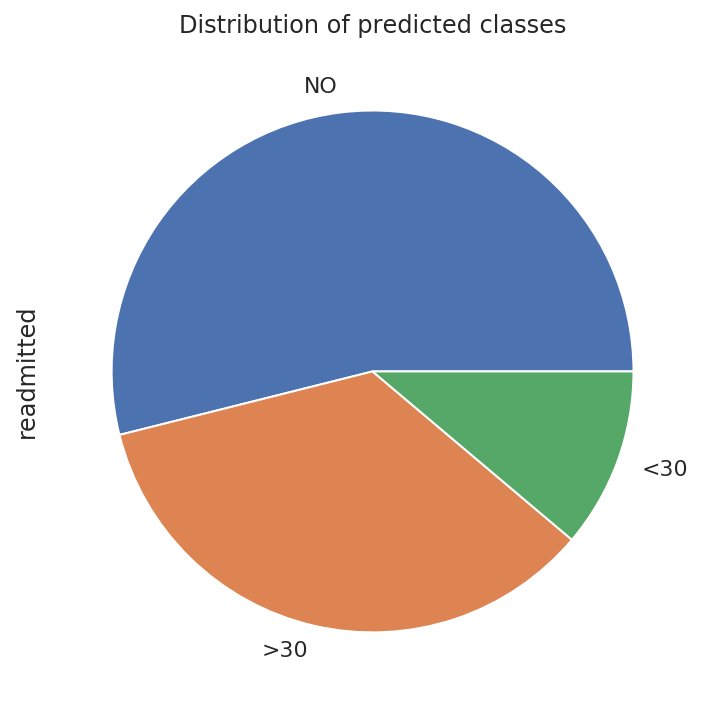

In [11]:
df.readmitted.value_counts().plot(kind='pie', title='Distribution of predicted classes');

In [12]:
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

### Missing values

From first view of the data, we could see that there are also missing values. We could see also some rows with *None* values, but those values mean that measurement was not done (according to paper that published this dataset). In those cases, *None* value does not represent missing value - information about not performing the measurement can be helpful when predicting patient readmission.

Let's check which columns have missing values and how many (the bar represents the fraction of data that are available - lower the bar, the more missing values are there):

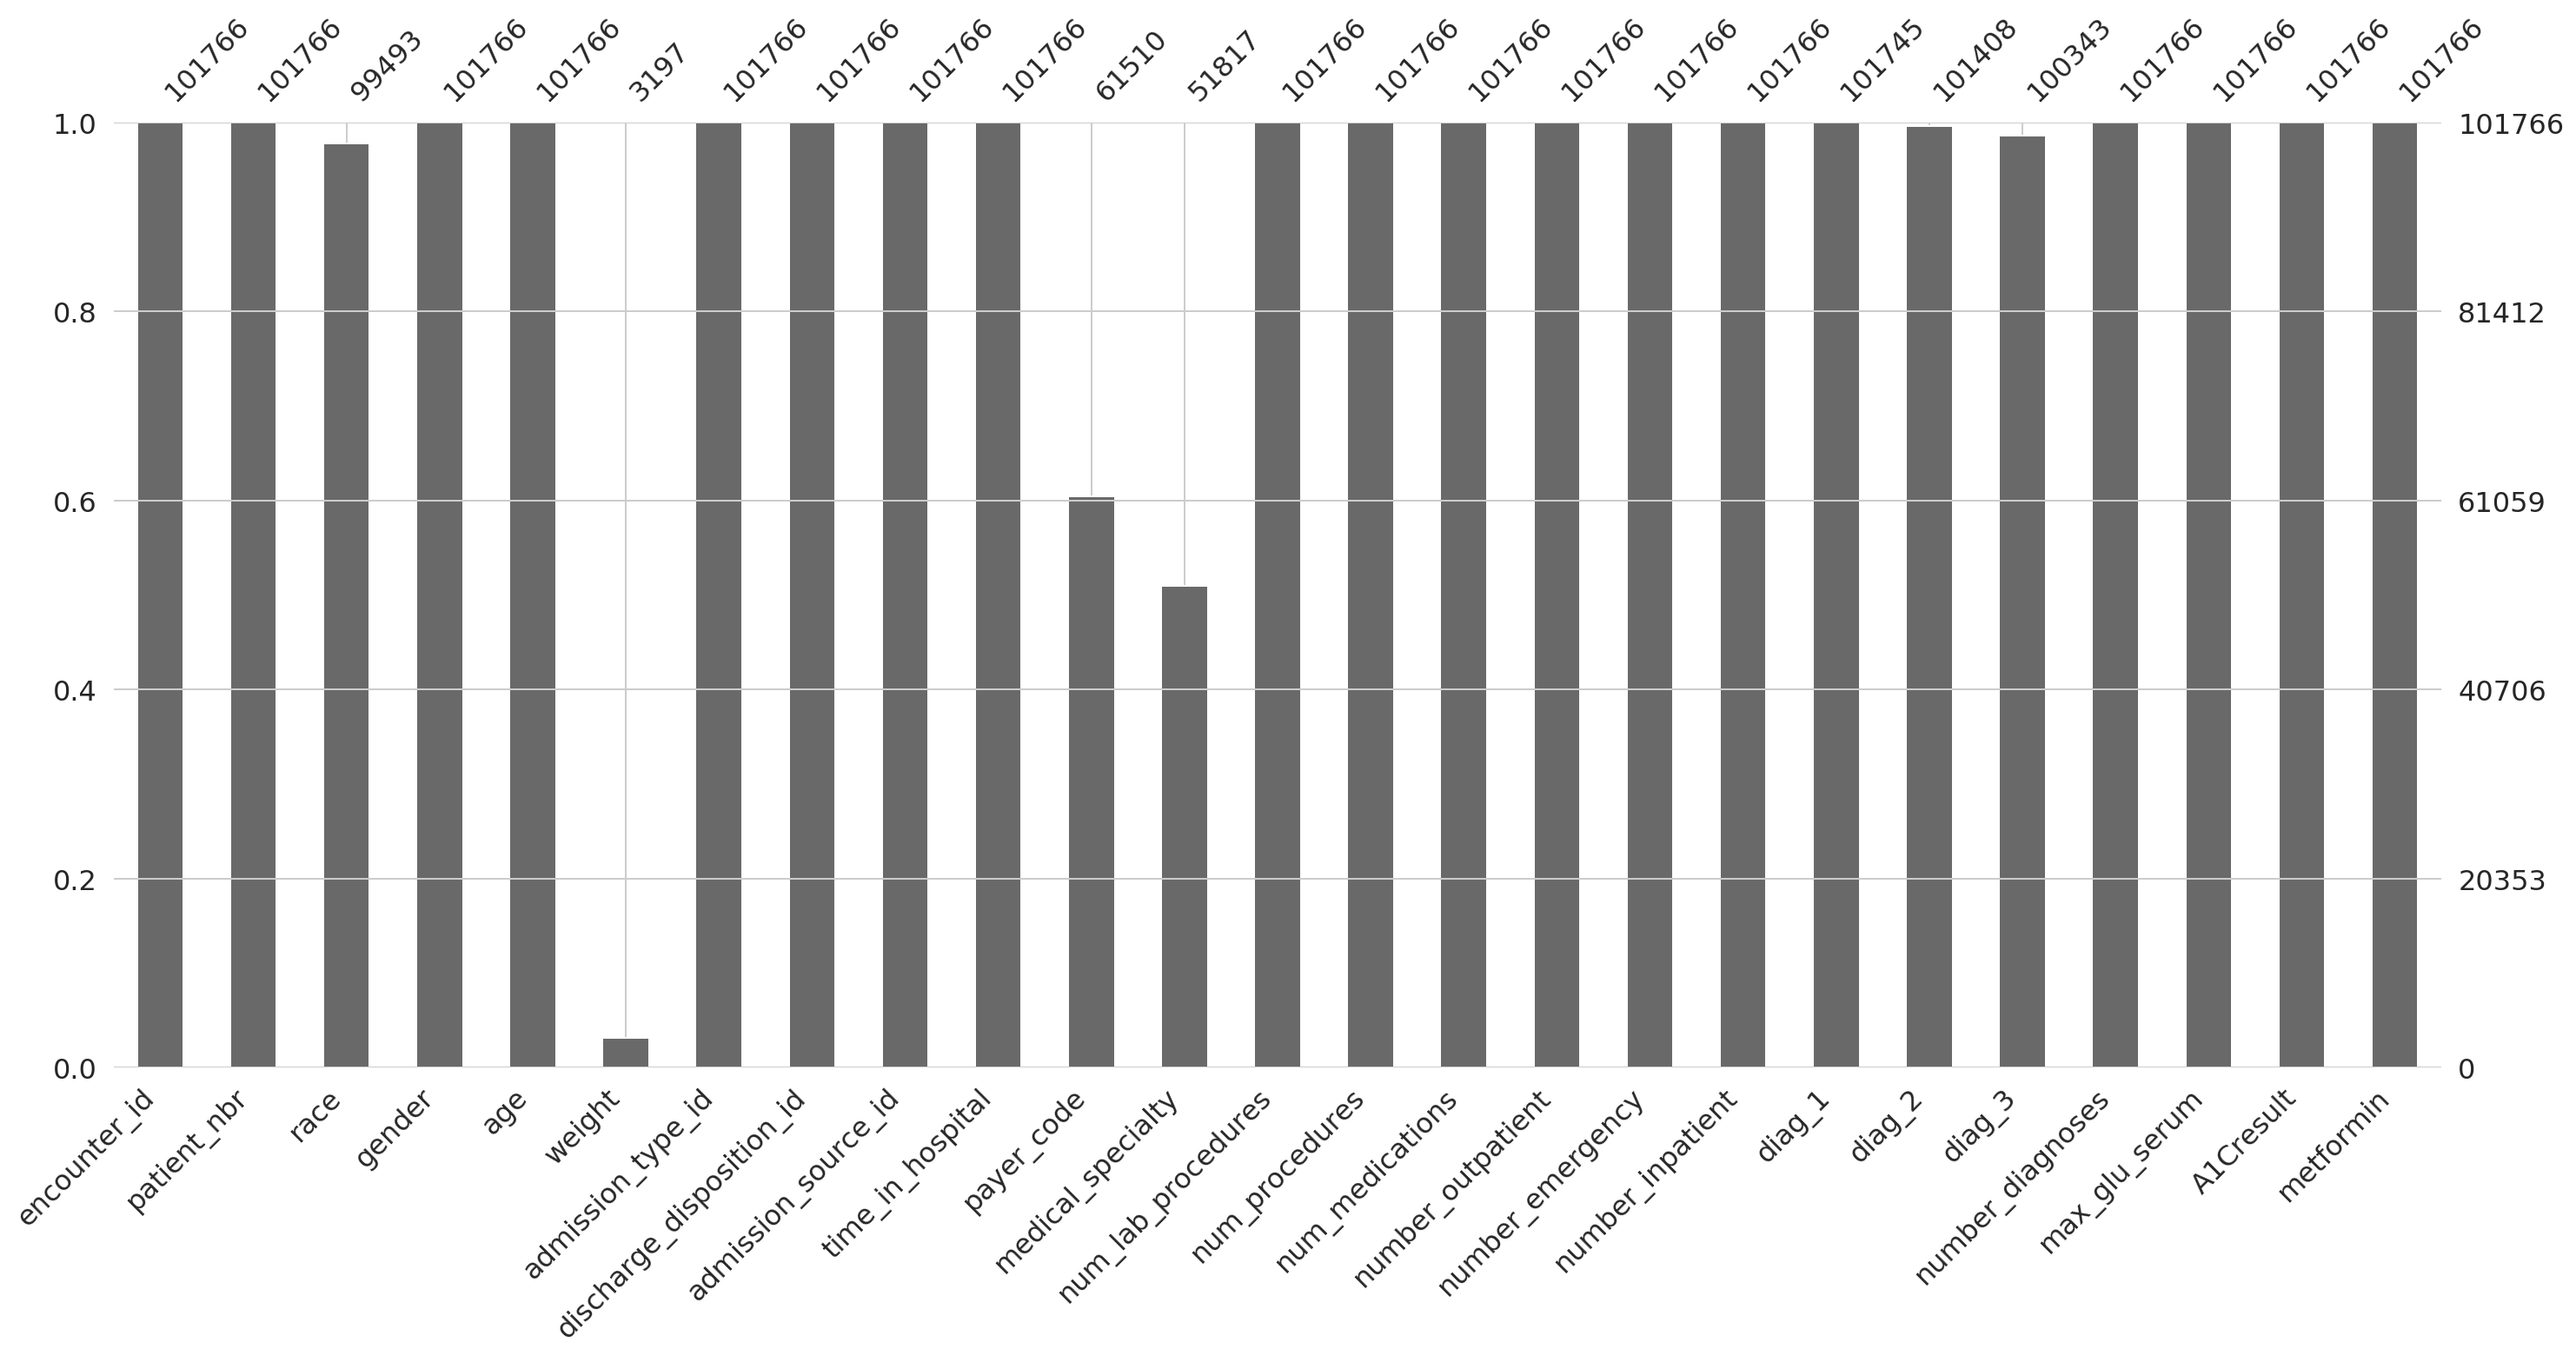

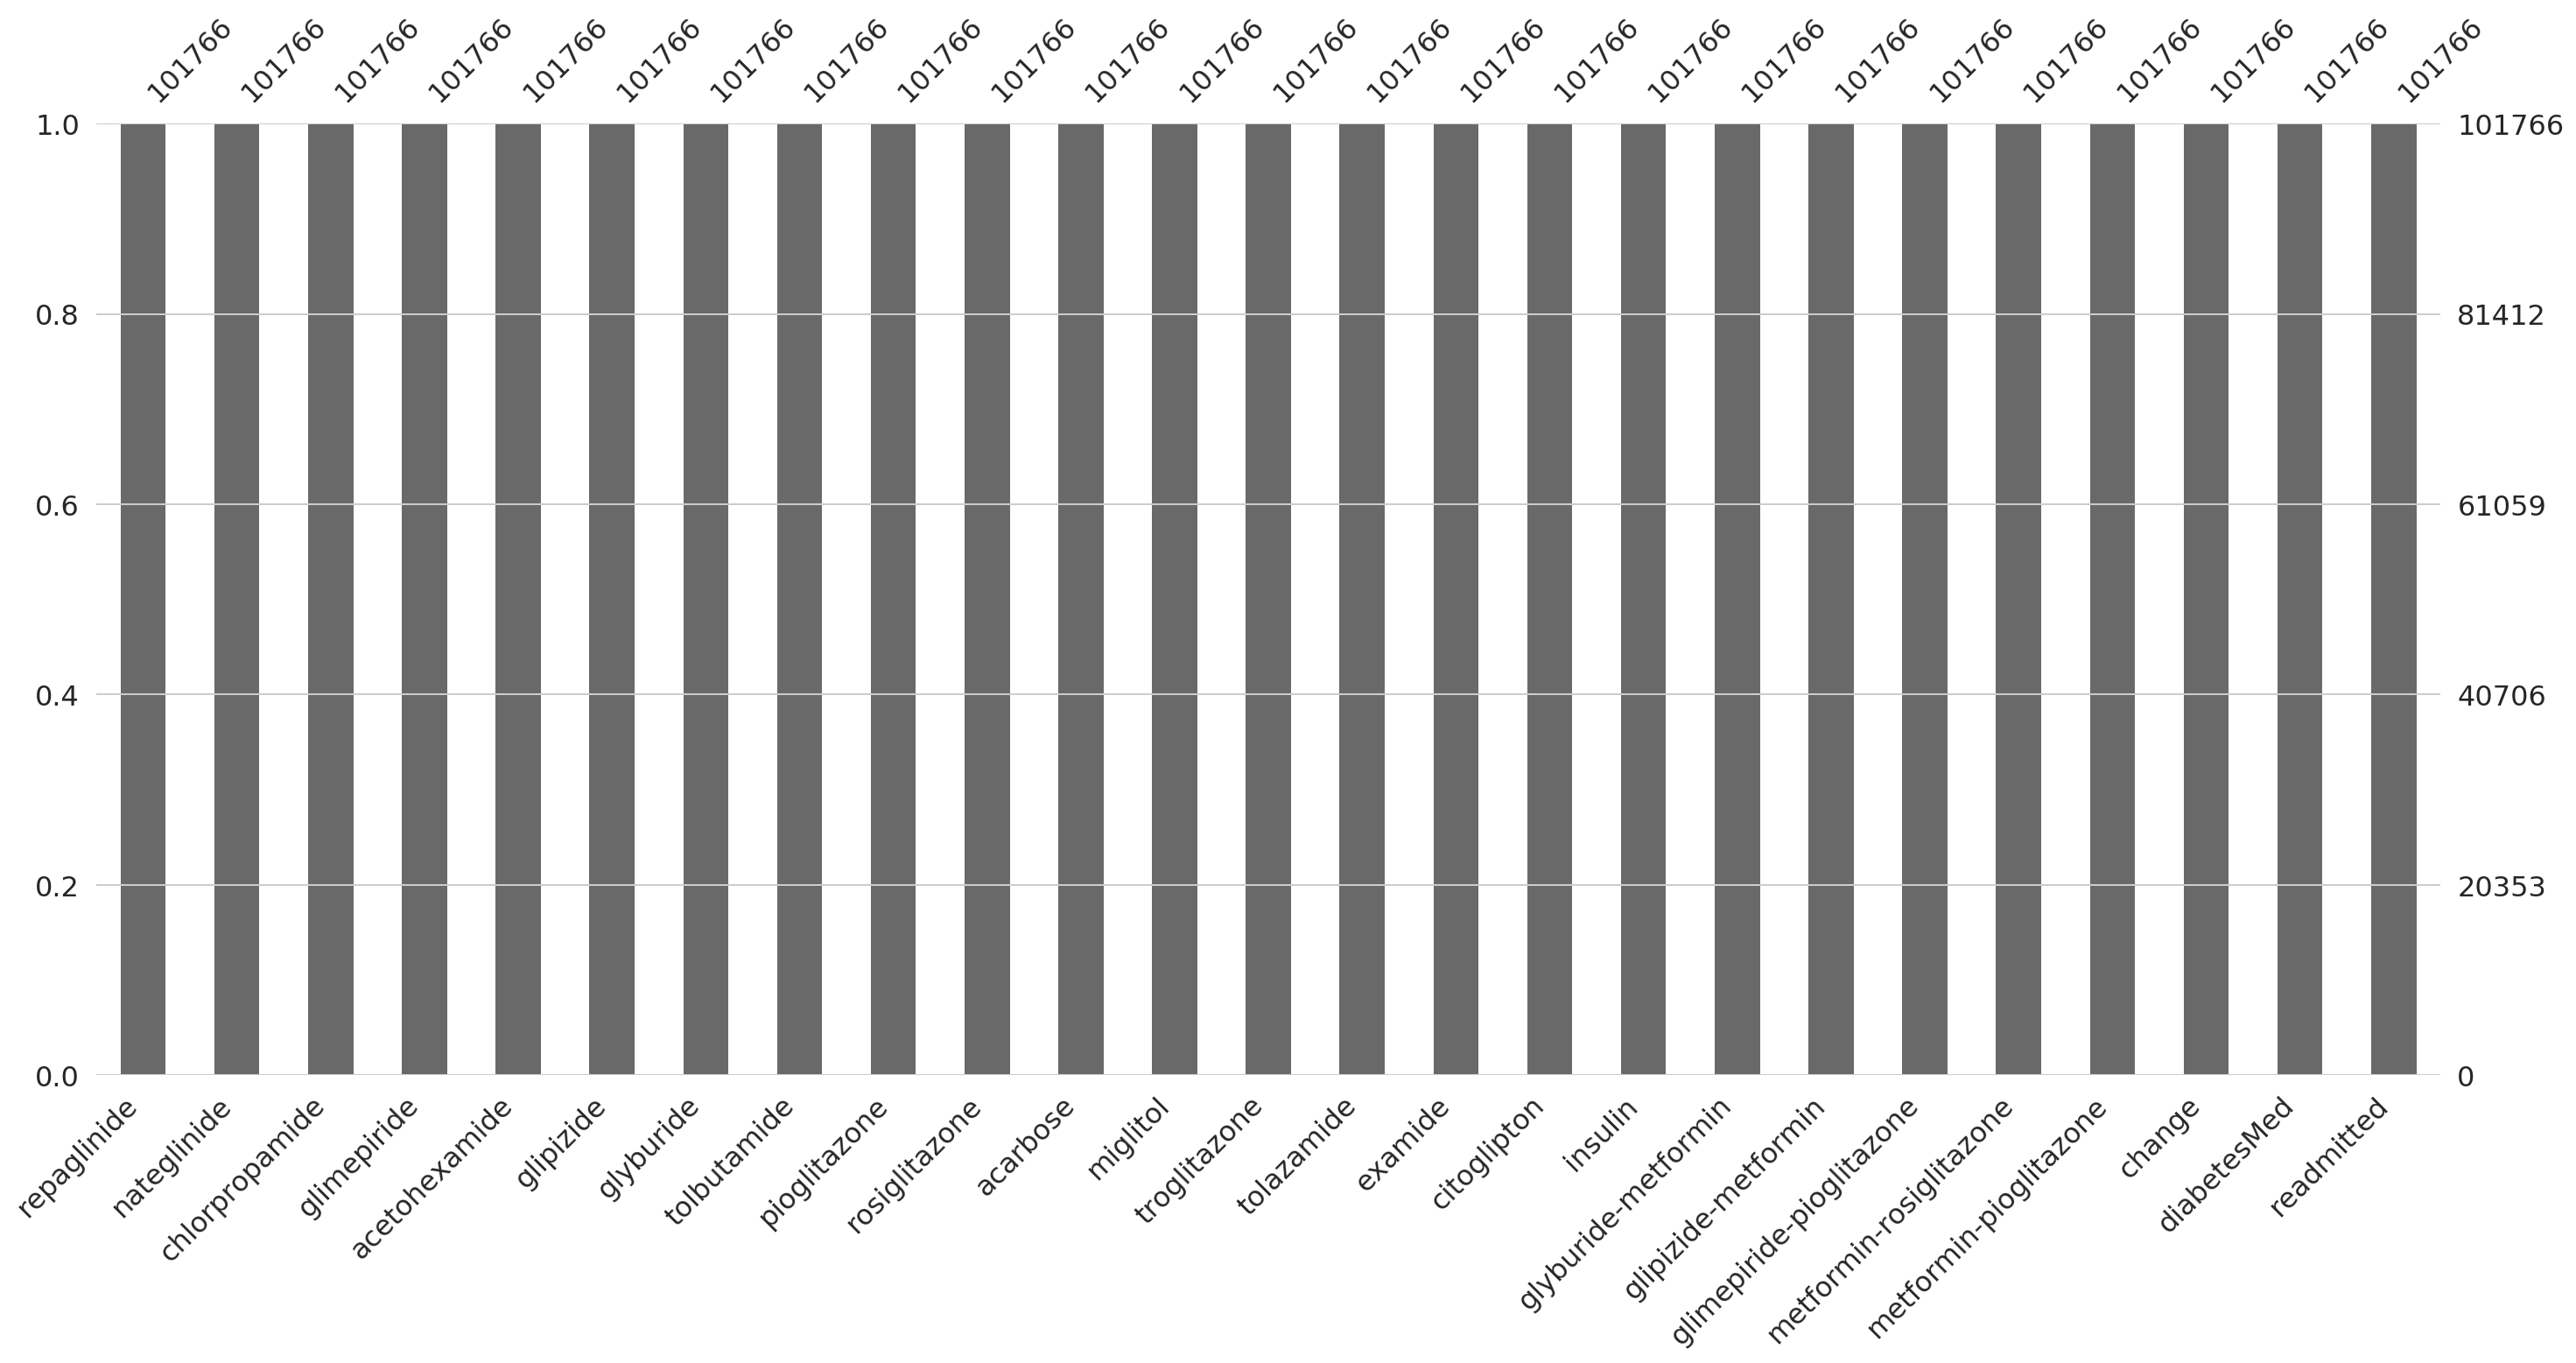

In [13]:
# Divide columns to 2 groups (too many columns for one plot)
column_groups = np.array_split(df.columns, 2)

for columns in column_groups:
    msno.bar(df[columns])
    plt.show()

### Attributes analysis